In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torchvision import models
from utils.dataset import build_dataset
from utils.model import PAGenerator, class_model
from utils.visualize import GradCAM, get_heatmap, get_heatmap_on_image
from utils.loss import get_results
from config import *

# Model performance

In [3]:
# load dataset
dataset = build_dataset(image_size=image_size, batch_size=batch_size)
test_dataset  = dataset.test(test_dir)

test data
fra:457  nor:560


In [4]:
checkpoint = torch.load("LOAD YOUR MODEL HERE")
model = PAGenerator(models.efficientnet_b0(pretrained=True))
model.load_state_dict(checkpoint, strict=True)
model.eval()
model.to(device)
print('model loaded to device')

/home/genius/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/genius/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model loaded to device


In [5]:
labels = []
preds  = []

for i_batch, sample_batched in enumerate(test_dataset):
    img   = sample_batched['image'].to(device)
    label = sample_batched['label'].to(device)
    pred, _ = model(img)
    labels.append(label.tolist()[0])
    preds.append(pred.tolist()[0][0])
    print(i_batch, end='\r')

In [6]:
acc, sen, spc, ydn = get_results(preds, labels, threshold=0)
print(f'acc: %.4f   sen: %.4f   spc:%.4f   ydn:%.4f'%(acc, sen, spc, ydn))

acc: 0.9597   sen: 0.9212   spc:0.9911   ydn:0.9123


# GradCAM

In [7]:
# Load the weights of PAGAN to a classification model
cmodel = class_model(models.efficientnet_b0(pretrained=True))
cmodel.load_state_dict(model.state_dict(), strict=False)
cmodel.eval()
print('done')

done


/home/genius/anaconda3/lib/python3.10/site-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


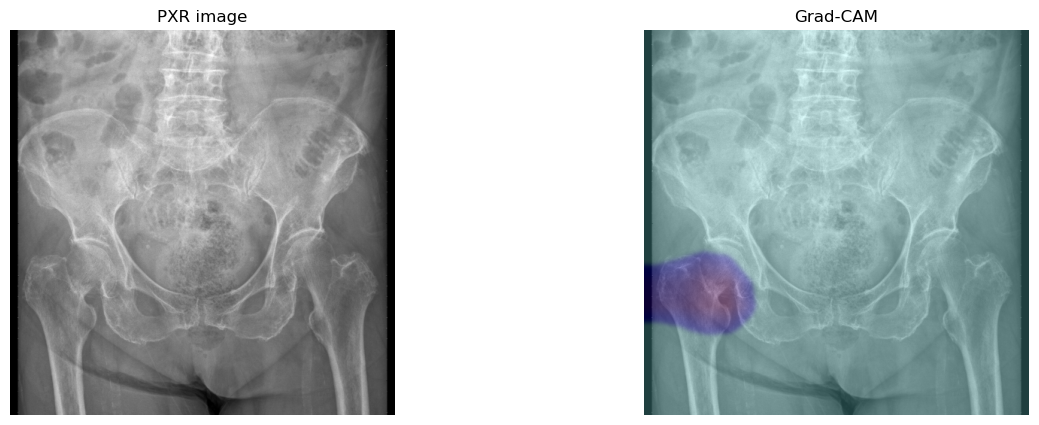

In [8]:
# choose image
idx = 2
for i_batch, sample_batched in enumerate(test_dataset):
    img_tensor = sample_batched['image']
    if i_batch==idx:
        break

# to RGB
img = img_tensor.detach().numpy()[0][0]
img = np.uint8(255 * img)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
ori_img = img.copy()
img = img - np.min(img)
img = img / np.max(img)

# define heatmap
gradcam       = GradCAM(cmodel)
heatmap       = gradcam(img_tensor, index=0)
heatmap       = get_heatmap(heatmap)
heatmap_image = get_heatmap_on_image(heatmap, img)

# visualize
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title(f'PXR image')
plt.axis('off')
plt.imshow(img, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Grad-CAM')
plt.axis('off')
plt.imshow(heatmap_image/heatmap_image.max())